In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import copy

import matplotlib.pyplot as plt
import neuromodels as nm
import numpy as np
import pandas as pd
import pylfi
import quantities as pq
import scipy.stats as stats
import seaborn as sns

from utils import *

[INFO] [2021.10.26 2:11:30 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2021.10.26 2:11:30 /Users/runner/miniforge3/conda-bld/nest-simulator_1633677025151/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.2
 Built: Oct  8 2021 07:17:41

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
size = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": size,
    "font.size": size,
    "legend.fontsize": size,
    "xtick.labelsize": size-1,
    "ytick.labelsize": size-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
plt.rc('text', usetex=True)

# Set path to save the figures
FIGURE_PATH = "./../latex/figures" 
TABLE_PATH = "./../latex/tables" 

def fig_path(fig_id):
    """
    Input name of figure to load or save with extension as dtype str
    """
    return os.path.join(FIGURE_PATH + "/", fig_id)


def tab_path(tab_id):
    """
    Input name of table to load or save with extension as dtype str
    """
    return os.path.join(TABLE_PATH + "/", tab_id)


def df_to_latex(df, outfile):
    """
    Render dataframe to a LaTeX tabular environment table and write to file
    """
    n = len(df.columns)
    col_format = n * 'c'
    # Render dataframe to a LaTeX tabular environment table and write to file
    pd.options.display.float_format = '{:,.3f}'.format
    df = df.apply(lambda x: x.astype(
        int) if np.allclose(x, x.astype(int)) else x)
    pd.options.display.latex.escape = False
    latex = df.to_latex(index=False, column_format=col_format)
    latex = latex.replace('\\toprule', '\\hline \\hline')
    latex = latex.replace('\\midrule', '\\hline \\hline')
    latex = latex.replace('\\bottomrule', '\\hline \\hline')

    with open(tab_path(outfile), 'w') as f:
        f.write(latex)

# Set figure size
pt = 410 #360

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

fs = set_size(pt, fraction=1)
print(fs)

(5.673170056731701, 3.5062119190183605)


In [4]:
path = "data/"

## Functions

In [5]:
def compute_rmspe(theta_true, theta_pred):
    """Root mean square percentage error (RMSPE)"""
    rmspe = np.sqrt(np.mean(np.square((theta_true - theta_pred) / theta_true)))
    return rmspe * 100

def compute_point_est(theta, density, point_estimate):
    """Compute point estimate"""
    if point_estimate == "mean":
        p_est = theta.mean()
        handle = "mean"
    elif point_estimate == "median":
        p_est = np.median(theta)
        handle = "median"
    elif point_estimate == "map":
        idx = np.argmax(density)
        p_est = theta[idx]
        handle = "MAP"
    return p_est, handle

def compute_hdi(theta, hdi_prob):
    """Highest (posterior) density interval"""
    theta = theta.flatten()
    n = len(theta)
    theta = np.sort(theta)
    interval_idx_inc = int(np.floor(hdi_prob * n))
    n_intervals = n - interval_idx_inc
    interval_width = np.subtract(theta[interval_idx_inc:],
                                 theta[:n_intervals],
                                 dtype=np.float_
                                 )
    min_idx = np.argmin(interval_width)
    hdi_min = theta[min_idx]
    hdi_max = theta[min_idx + interval_idx_inc]
    return (hdi_min, hdi_max)


def plot_posterior(df, theta_name, theta_true, point_estimate='map', hdi_prob=0.95, ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    xdata = df[theta_name].to_numpy() 
    theta_true_ary = np.ones(len(xdata.flatten())) * theta_true
    rmspe = compute_rmspe(theta_true_ary, xdata)
    
    sns.kdeplot(data=df,
                x=theta_name,
                color='C0',
                label=f"Posterior RMSPE: {rmspe:.2f}\%",
                ax=ax
            )

    ax.axvline(theta_true,
               ymax=0.3,
               color='C3',
               label=fr"$\theta_\mathrm{{true}}: {theta_true}$"
              )
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()

    p_est, p_est_handle = compute_point_est(xs, ys, point_estimate)

    hdi_min, hdi_max = compute_hdi(xdata, hdi_prob=hdi_prob)

    ax.vlines(
        p_est,
        0,
        np.interp(p_est, xs, ys),
        color='b',
        ls=':',
        label=fr"$\hat{{\theta}}_\mathrm{{{p_est_handle}}}: {p_est:.3f}$"
    )

    ax.fill_between(
        xs,
        0,
        ys,
        facecolor='lightblue',
        alpha=0.3
    )

    ax.fill_between(
        xs,
        0,
        ys,
        where=(hdi_min <= xs) & (xs <= hdi_max),
        interpolate=True,
        facecolor='steelblue',
        alpha=0.3,
        label=f"{hdi_prob*100}\% HDI: [{hdi_min:.3f}, {hdi_max:.3f}]"
    )

    handles, labels = ax.get_legend_handles_labels()

    ax.set(yticks=[])

    ax.legend(
        handles,
        labels,
        loc='center left',
        bbox_to_anchor=(1.04, 0.5),
        fancybox=True,
        borderaxespad=0.1,
        ncol=1,
        frameon=False
    )
    
    
def plot_joint(df, theta1_name, theta2_name, theta1_true=None, theta2_true=None, levels=6, alpha=0.3, height=4, **kwargs):

    g = sns.jointplot(
        data=df,
        x=theta1_name,
        y=theta2_name,
        kind="kde",
        fill=True,
        height=height,
        **kwargs
    )

    g.plot_joint(
        sns.kdeplot,
        color="k",
        levels=levels,
        alpha=alpha
    )

    if theta1_true is not None and theta2_true is not None:
        g.ax_joint.plot([theta1_true], [theta2_true], 'ro')
        g.ax_joint.axvline(theta1_true, color='r', ls=":")
        g.ax_joint.axhline(theta2_true, color='r', ls=":")
        g.ax_marg_x.axvline(theta1_true, color='r')
        g.ax_marg_y.axhline(theta2_true, color='r')

    return g

## Simulator and observation

In [6]:
# Simulator model
T = 120           # Simulation time [ms]
dt = 0.025        # Time step [ms]
I_amp = 10        # Input stimuls amplitude [microA/cm^2]
t_stim_on = 10    # Stimulus onset [ms]
t_stim_off = 110  # Stimulus offset [ms]
stimulus = nm.stimulus.Constant(I_amp, t_stim_on, t_stim_off)
hh = nm.models.HodgkinHuxley(stimulus, T, dt)

# Summary statistics calculator
s_stats = ["average_AP_overshoot",
           "spike_rate",
           "average_AP_width",
           "average_AHP_depth",
           ]

sps = nm.statistics.SpikeStats(t_stim_on=t_stim_on,
                               t_stim_off=t_stim_off,
                               stats=s_stats
                               )

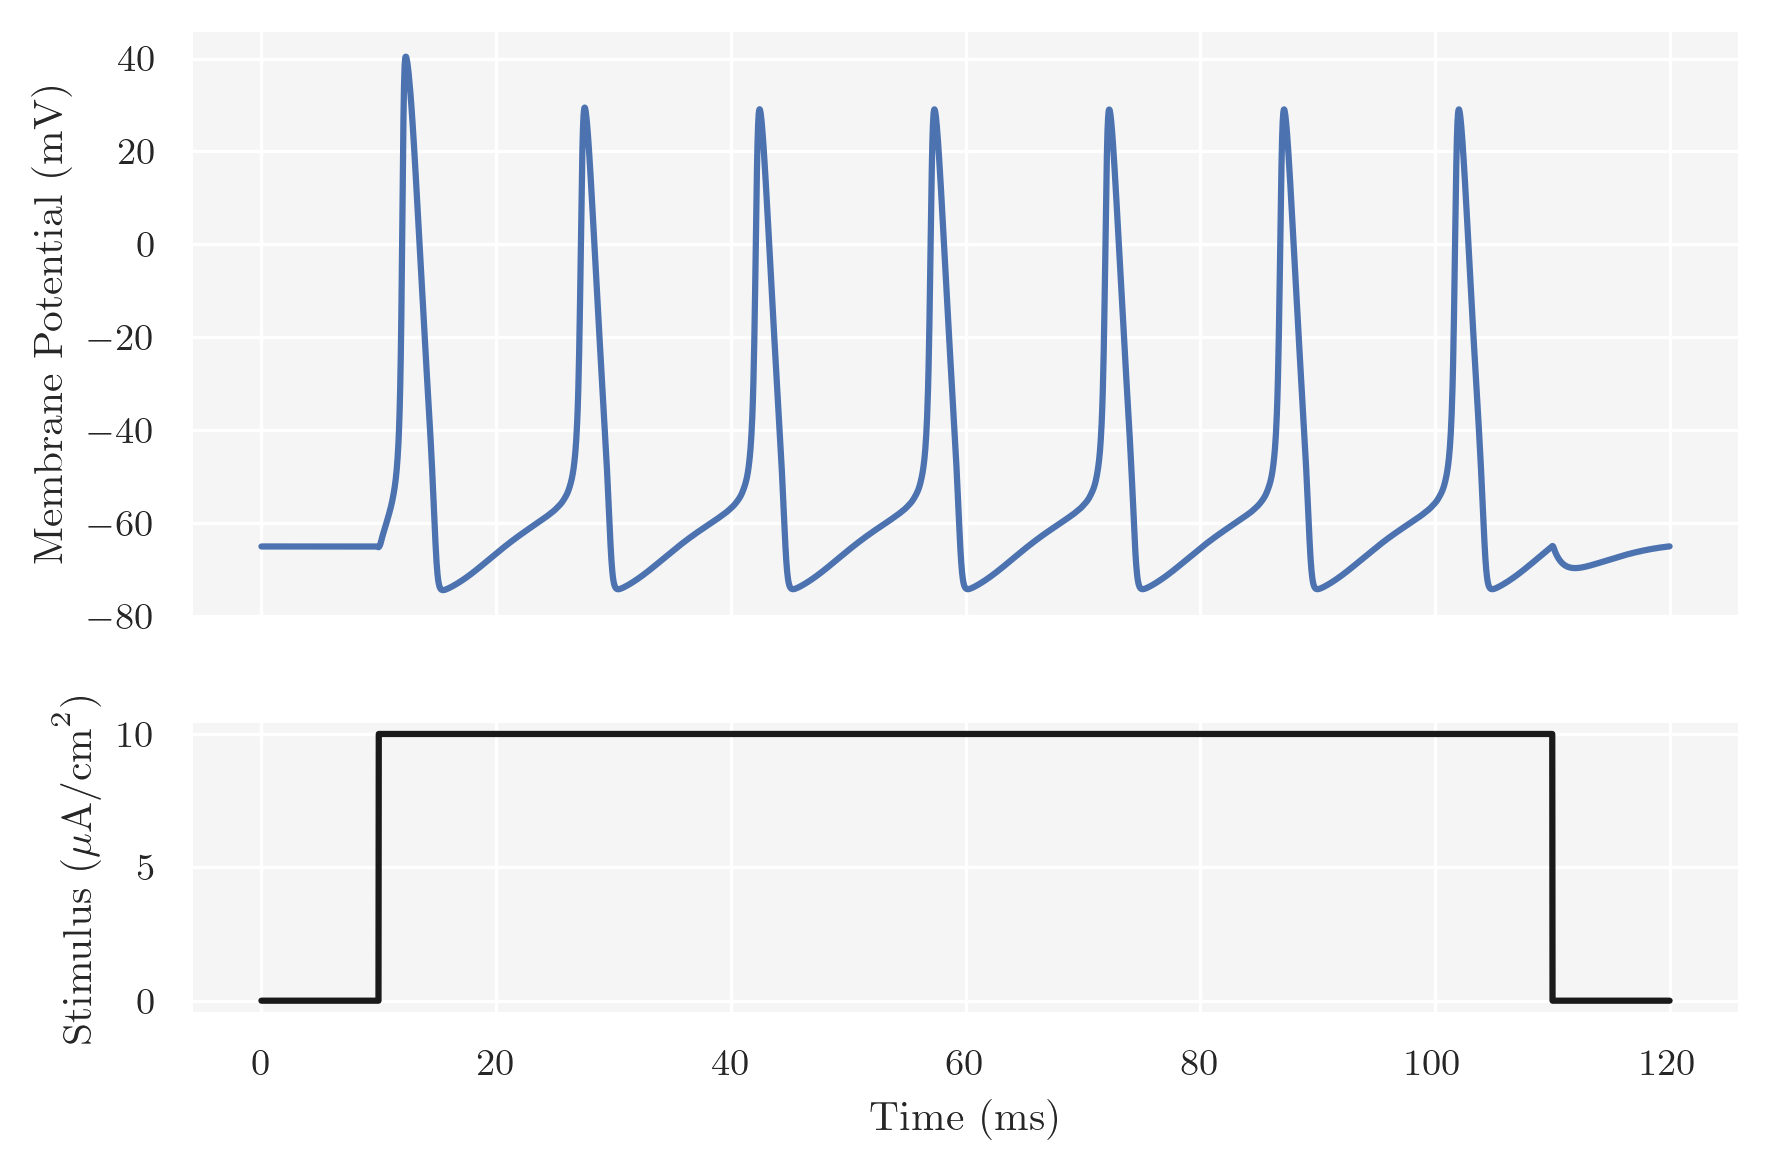

In [7]:
gbarK_true = 36.
gbarNa_true = 120.

obs = hh(gbarK_true, gbarNa_true)
hh.plot_voltage_trace(with_stim=True)
plt.show()

In [8]:
s_obs = sps(*obs)
s_obs

[30.731559538521424, 0.07, 2.0501332397579985, -74.22338615416054]

In [25]:
posterior = load_posterior('data/hh_posterior.pkl')
thetas = posterior.sample((1000,), x=s_obs)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [26]:
param_names =  [r'$\bar{g}_\mathrm{K}$', r'$\bar{g}_\mathrm{Na}$']
data = dict(zip(param_names, np.stack(thetas, axis=-1)))
df = pd.DataFrame.from_dict(data)
df

,$\bar{g}_\mathrm{K}$,$\bar{g}_\mathrm{Na}$
0,36.245892,119.581390
1,36.134483,119.979736
2,35.796913,120.604004
3,36.010761,119.835297
4,35.991585,119.840813
...,...,...
995,36.065357,119.883469
996,36.051891,120.156639
997,35.792782,119.511124
998,36.039150,120.326157


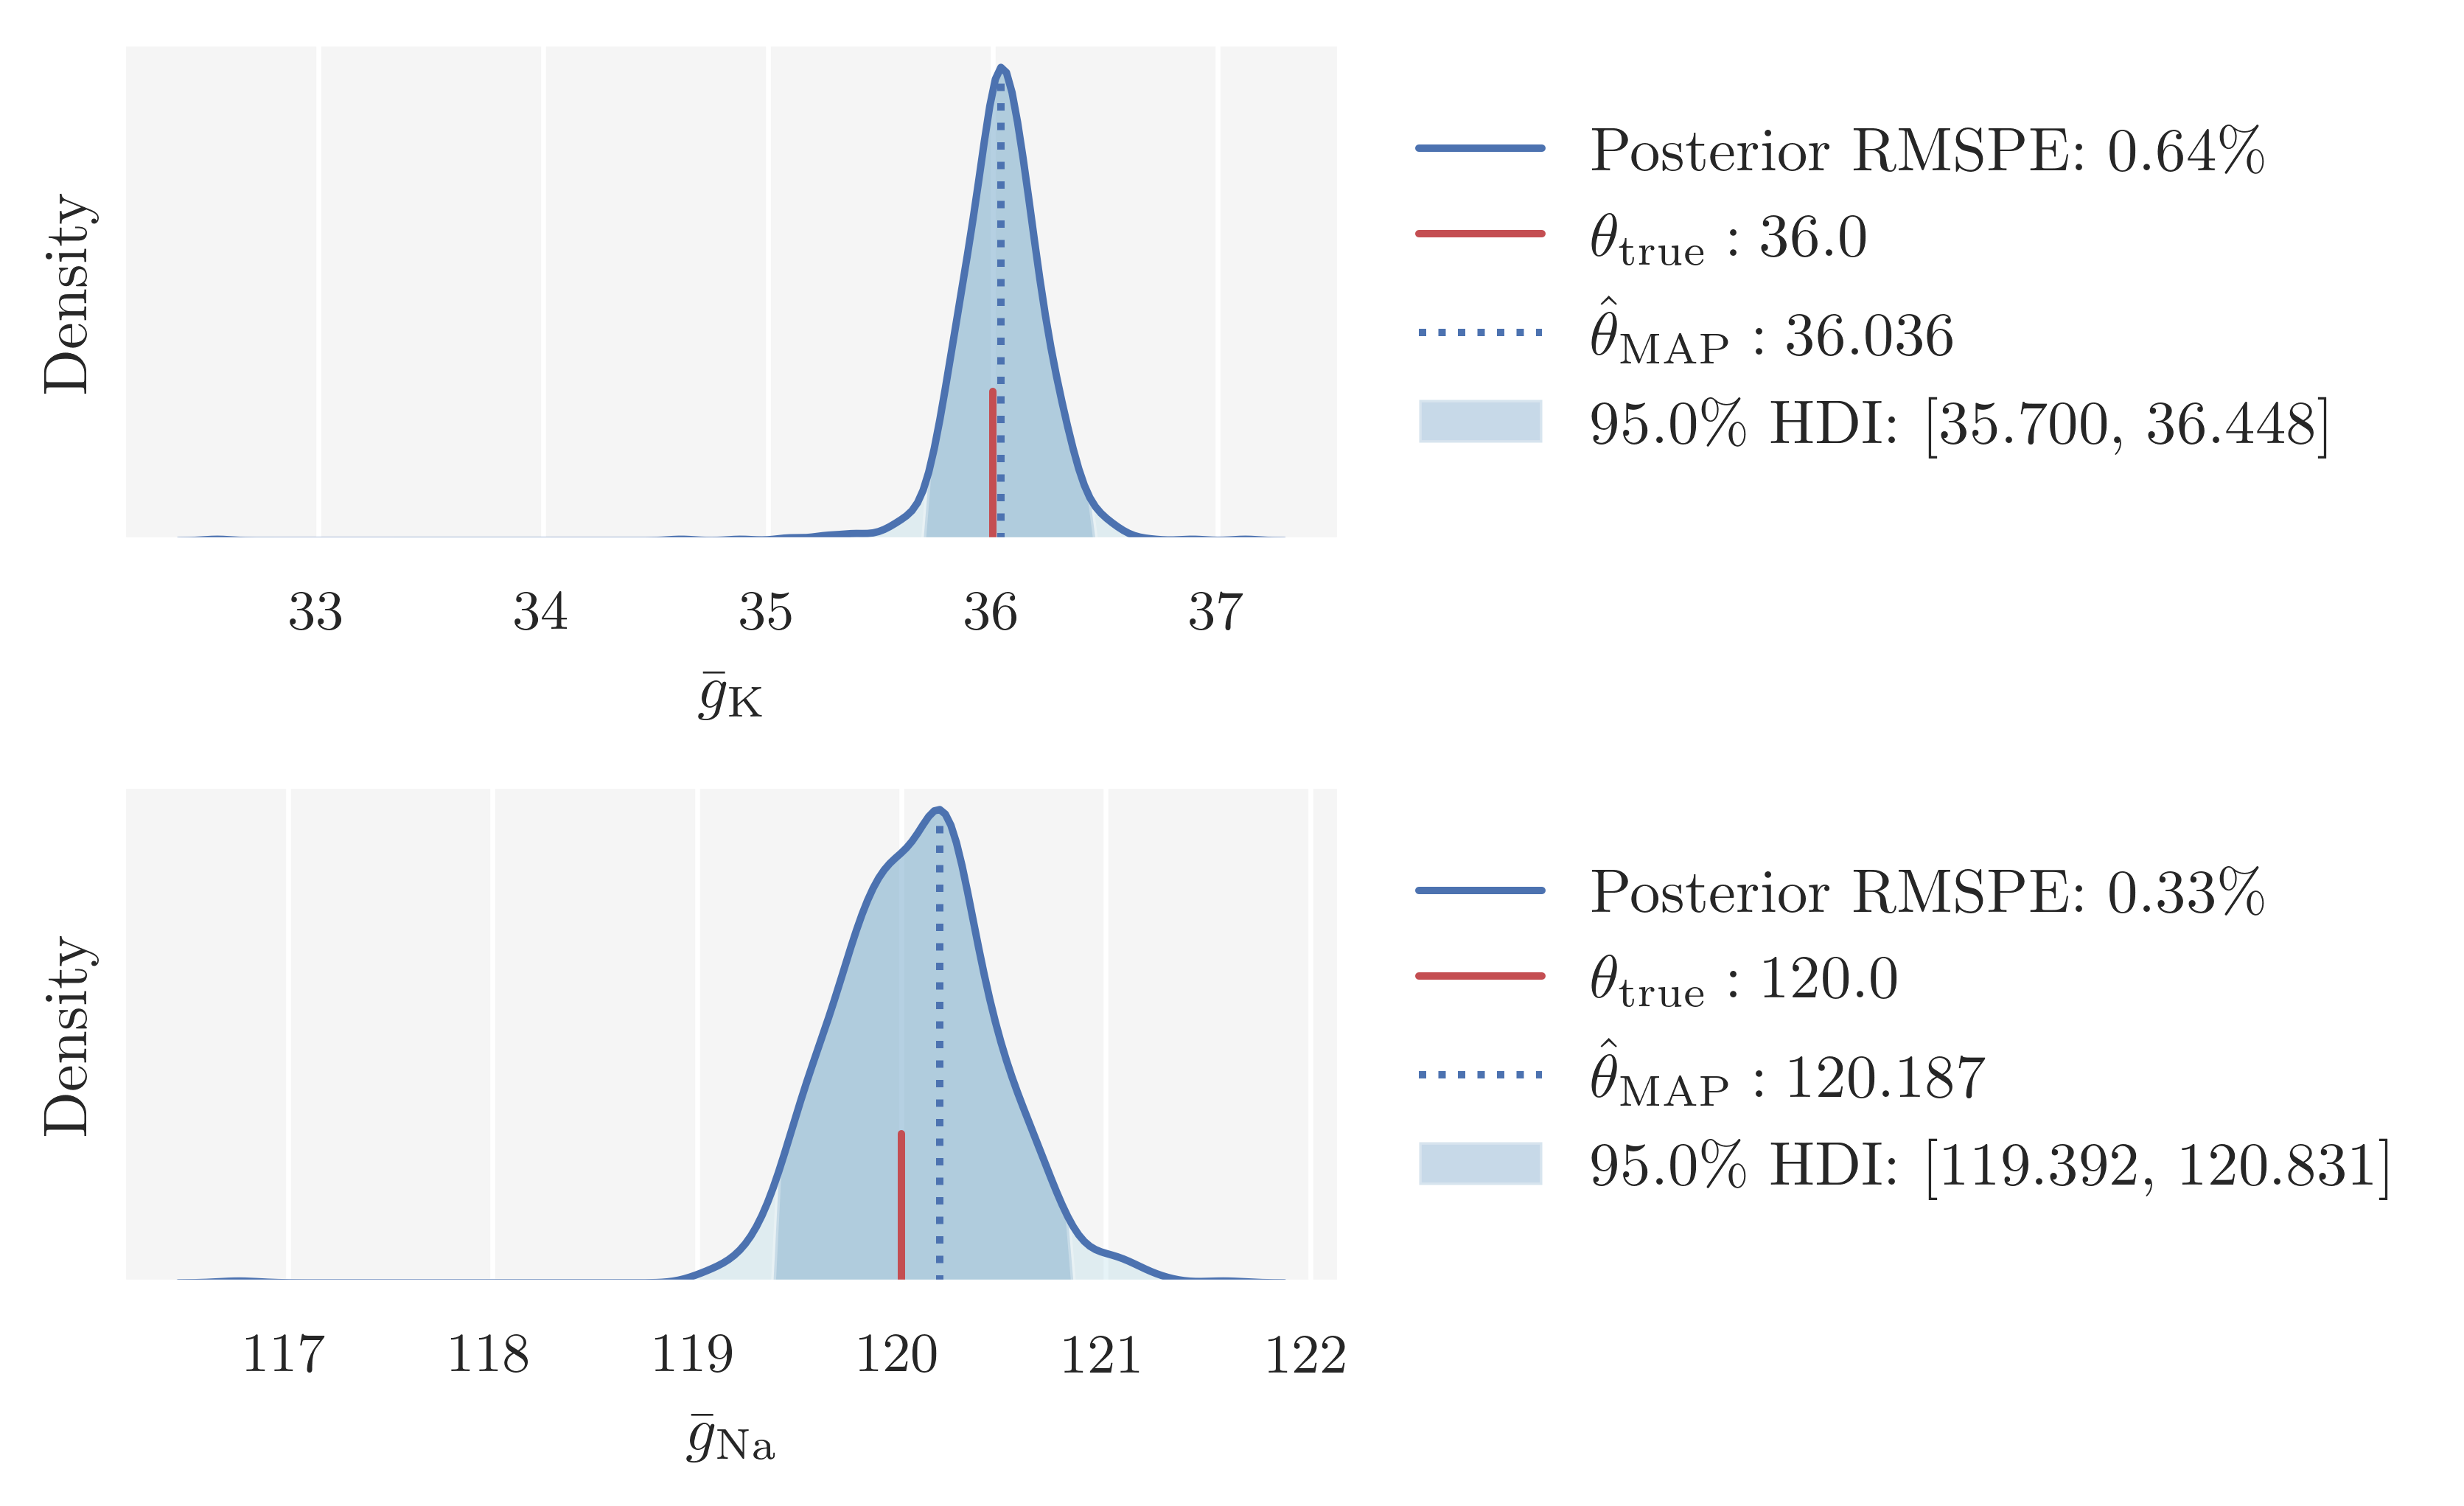

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
plot_posterior(df, r'$\bar{g}_\mathrm{K}$', point_estimate='map', theta_true=gbarK_true, ax=axes[0])
plot_posterior(df, r'$\bar{g}_\mathrm{Na}$', point_estimate='map', theta_true=gbarNa_true, ax=axes[1])

fig.savefig(fig_path('hh_post_sbi.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

In [28]:
def hh_posterior_predictive(obs_data, simulator, thetas_pred, ax=None):
    if ax is None:
        ax = plt.gca()
        
    post_preds = np.array([hh(*theta) for theta in thetas_pred])
    mean_pred = np.mean(post_preds, axis=0)
    
    p1, = ax.plot(obs_data[1], obs_data[0], color='k', lw=1.0, zorder=1)
    
    for pred in post_preds:
        p2, = ax.plot(pred[1], pred[0], color='C0', alpha=0.2, zorder=0)
    
    p3, = ax.plot(mean_pred[1], mean_pred[0], color='C1', ls='--', dashes=(5, 5), lw=1.0, zorder=2)
    
    ax.set(xlabel="Time (ms)",
           ylabel="Membrane Potential (mV)"
          )
    
    ax.legend(
        [p1, p2, p3],
        ['Observation', 'Posterior predictive', 'Posterior predictive mean'],
        loc='center left',
        bbox_to_anchor=(1.04, 0.5),
        fancybox=True,
        borderaxespad=0.1,
        ncol=1,
        frameon=False
    )

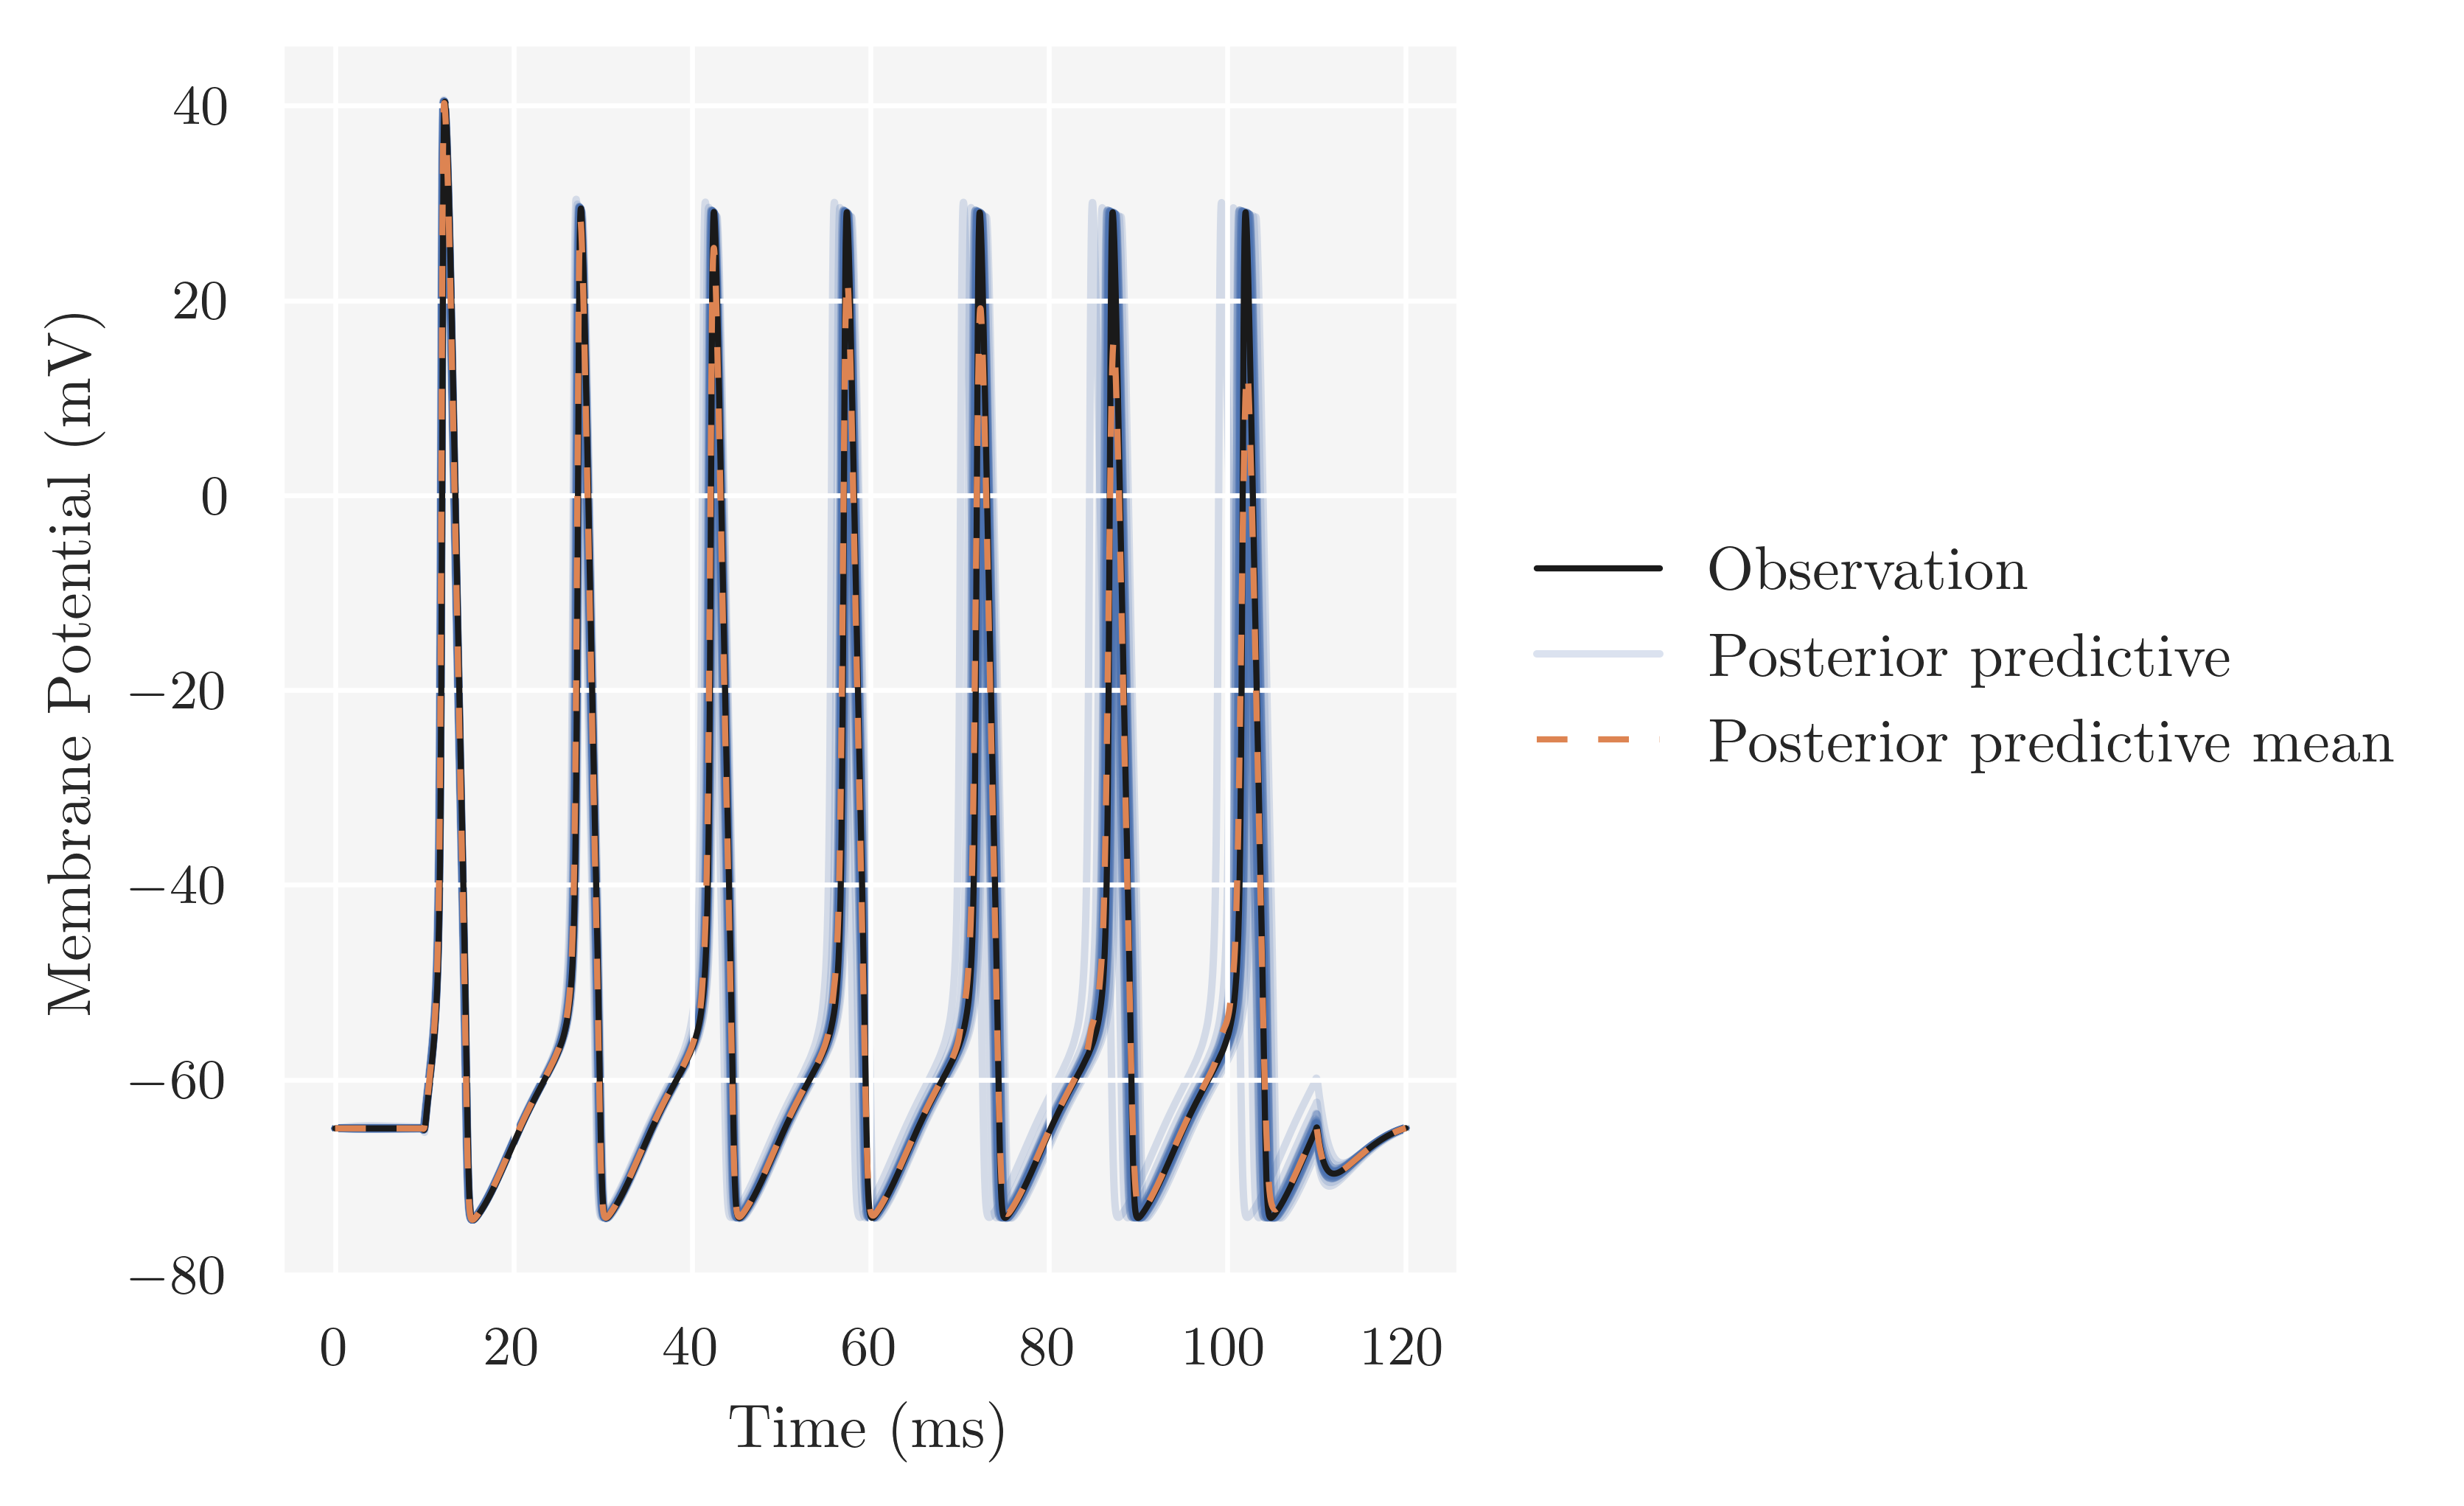

In [29]:
size = 50
idxs = np.random.randint(0, len(df.index), size)
thetas_pred = df.iloc[idxs].to_numpy()

#thetas_pred = posterior.sample((1,), x=s_obs).numpy()
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
hh_posterior_predictive(obs, hh, thetas_pred, ax=ax)

fig.savefig(fig_path('hh_post_pred_sbi.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

## Noisy data

Not very interesting, perhaps not include or put in appendix

In [31]:
df_hh_noisy = pd.read_csv('data/hh_noisy.csv')
V = df_hh_noisy["V"].to_numpy()
t = df_hh_noisy["t"].to_numpy()
obs_data = (V, t)
s_obs = sps(*obs_data)

thetas2 = posterior.sample((1000,), x=s_obs)

data2 = dict(zip(param_names, np.stack(thetas2, axis=-1)))
df2 = pd.DataFrame.from_dict(data2)
df2

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

,$\bar{g}_\mathrm{K}$,$\bar{g}_\mathrm{Na}$
0,37.572914,122.854233
1,37.284424,123.017906
2,37.826054,123.509201
3,37.935944,123.742134
4,37.485462,122.649231
...,...,...
995,37.563530,123.024254
996,37.399265,122.991653
997,37.875240,123.673462
998,37.663734,123.092720


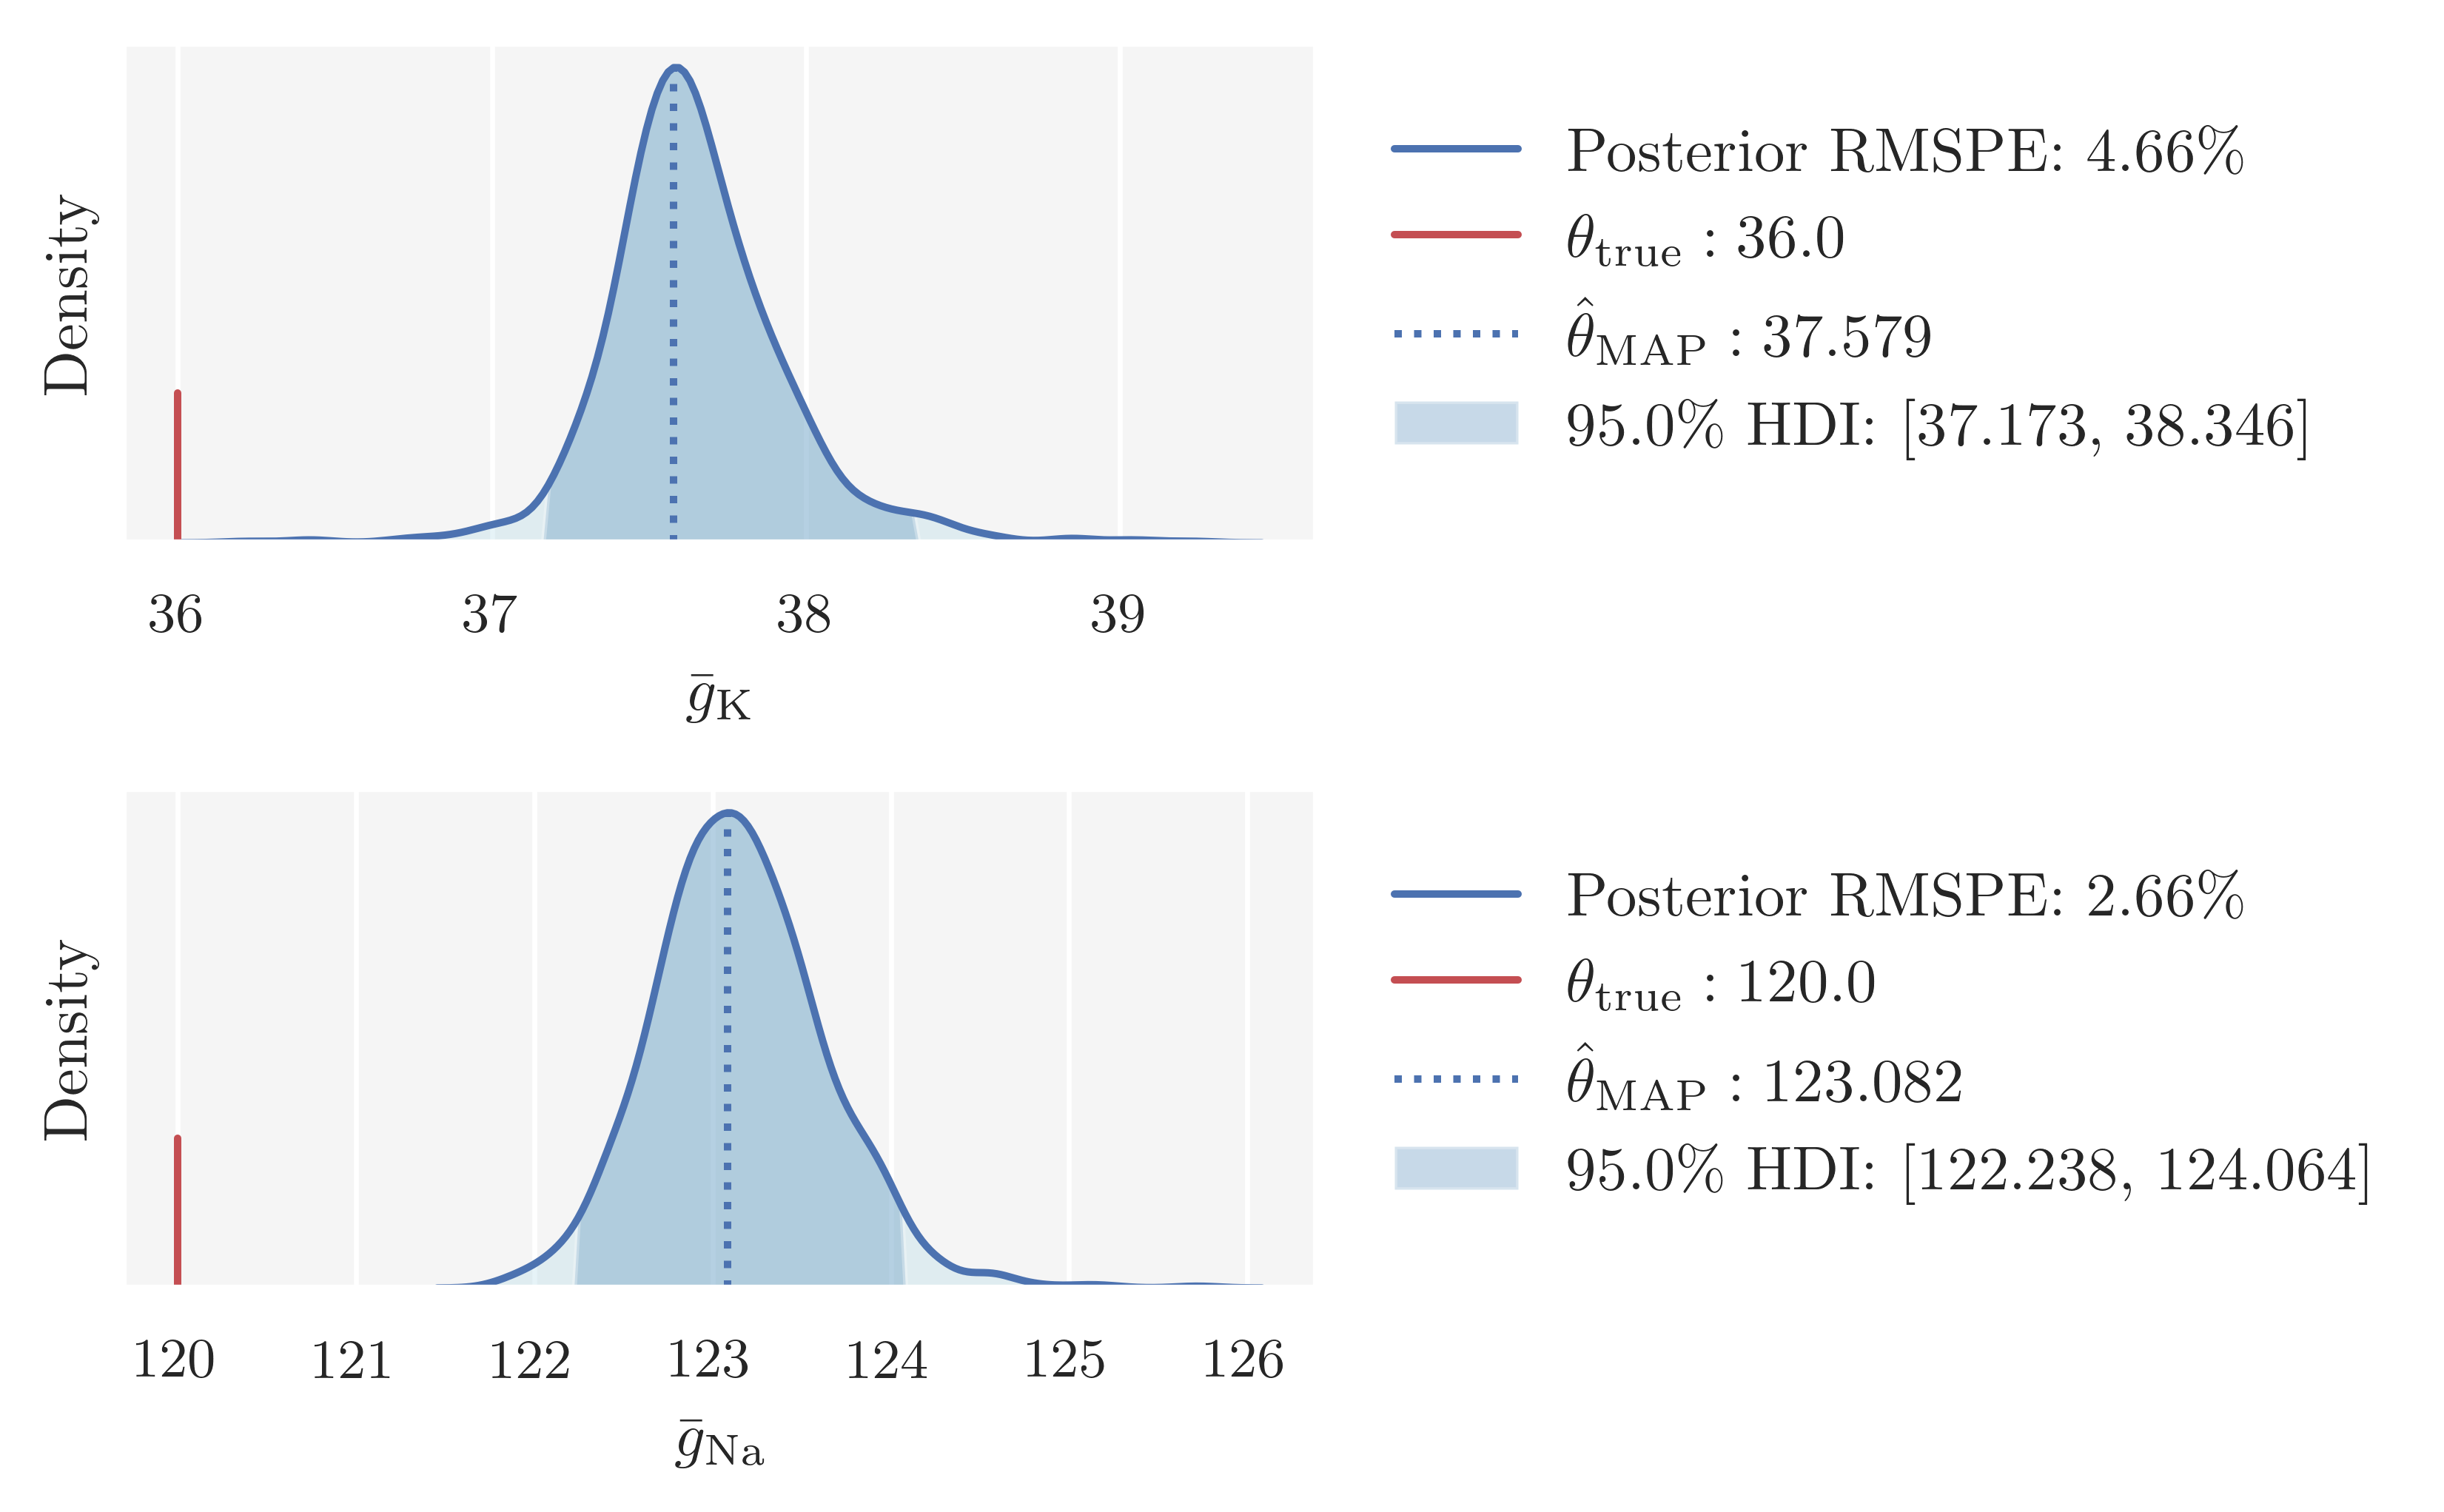

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
plot_posterior(df2, r'$\bar{g}_\mathrm{K}$', point_estimate='map', theta_true=gbarK_true, ax=axes[0])
plot_posterior(df2, r'$\bar{g}_\mathrm{Na}$', point_estimate='map', theta_true=gbarNa_true, ax=axes[1])
plt.show()

## SBI and NEST 

Unfortunately, SBI and NEST are incompatible at the moment. NEST does not support PyTorch data types, i.e., PyTorch Tensors, which SBI requires to train the neural network. 

In principle, the neural network based on SNPE algorithm should be able to learn the different states of the Brunel network, provided the summary statistics constrain all the states well. In particular, by using uniform priors that covers the parameter range of the SR and AI states, for instance $\pi(\eta) = \mathcal{U}(1.5, 4)$ and $\pi(g) = \mathcal{U}(1, 8)$, the network should be able to predict which of these states a set of summary statistics belongs to [rewrite this sentence]. Whether or not this is the case, remains to be studied. 


**The NEST error:**

`nest.lib.hl_api_exceptions.PyNESTError: unknown Python type: <class 'torch.Tensor'>`